In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *
import math


In [2]:
class Node(torch.nn.Module):
    def __init__(self, n, thresh, decay_rate = 0.95, expected_std = 0.1, lr = 1):
        super(Node, self).__init__()
        self.charges = torch.zeros([n])
        self.decay_rate = decay_rate
        self.lr = lr
        self.expected_std = torch.tensor(expected_std).float()
        
        self.weights = torch.zeros([n])
        #self.reset_parameters()
        
        self.thresh = thresh
        self.expected_error = 0
        
        self.weight_gain = 0.001
    
    def decay(self):
        #self.charges[self.charges % 1 > self.decay_rate] -= self.decay_rate
        #self.charges[self.charges < 0] = 0
        #self.charges[self.charges % 1 < self.decay_rate] -= self.charges % 1 
        self.charges *= self.decay_rate
        self.weights += self.weight_gain
        
    def nonlin(self, x):
        return torch.tanh(x)
    
    def nonlin_d(self, x):
        return 1 - (self.nonlin(x)**2)
    
    def forward(self, x):
        self.charges += x 
        self.decay()
        #print(self.charges)
        #print(self.expected_error)
        #print("##")
        print(self.weights,self.charges, self.expected_std, self.expected_error)
        
        v = self.get_charge()
        #print(v)
        if(v >= self.thresh):
            print("spike", self.weights)
            self.weights += -self.nonlin_d(self.charges * self.weights) * self.lr  * 0.1
            self.charges = torch.zeros(self.charges.shape)
            pass
        #self.weights[self.weights < 0] = 0
            
        return v
    
    def get_charge(self):
        return torch.sum(self.nonlin(self.charges * self.weights))
    
    def in_spike(self):
        error = (torch.ones([1]) - self.get_charge())# * 0.1
        #probabiliy error is from correct source given expected error
        dist_prob = (normal(error, self.expected_error, self.expected_std))
        #print(dist_prob)
        #print(dist_prob)
        delta_w = dist_prob * self.nonlin_d(self.charges * self.weights) * self.get_charge() * error * self.lr
        #print(error, self.weights, delta_w)
        self.weights += delta_w
        
        delta_er = (error - self.expected_error)# * 0.5#self.lr
        new_expected_error = self.expected_error + delta_er
        #self.new_expected_error = torch.ones([1]) - self.get_charge()
        
        
        #Welferd's method
        delta_std = (error-new_expected_error) * (error-self.expected_error)#(((error) - self.expected_std))[0]
        
        self.expected_error = self.new_expected_error
        #print(delta_std)
        self.expected_std += delta_std[0] 
        
        
        
        
        
    def reset_parameters(self):
        stdv = 0.1 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(0, stdv)
        
    
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = True, verbose = False, thresh = 1, lr = 0.1):
        super(SpikingNeuron, self).__init__()
        self.thresh = thresh
        self.n_out = n_out
        self.verbose = verbose
        self.lr = lr
        
        
        self.nodes = []
        for i in range(n_out):
            self.nodes.append(Node(n_out-1, thresh))
        
        self.weights = torch.zeros([n_out])
        
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        
        #If theres no incoming spikes don't bother doing any updates
        #if(in_spikes.shape[0] == 0):
        #    return torch.tensor([False]), self.voltage

        
        #Implication weight updates (input_spike -> input_spike)
        #for i in in_spikes:
            #counts = torch.cat((self.relative_spike_counts[i,:i], self.relative_spike_counts[i,i+1:]), dim = 1)
        #    errors = 1 - (counts * self.weights[i])
        #    errors[counts == 0] = 0
        #    self.weights[i] += errors
        in_spikes = x.squeeze().nonzero()
        for i in in_spikes:
            self.nodes[i].in_spike()
            
        spike = False
            
        for i, n in enumerate(self.nodes):
            
            ins = torch.cat((x[:i], x[i+1:]), dim = 0)
            if(n(ins) >= self.thresh):
                spike = True
   
        
        #Inhibition weight updates (input_spike -> outgoing spike)
            
        return spike, torch.tensor([0])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #-1
        #  \
        #   3
        #  /
        #-2
        self.spike1 = SpikingNeuron(2, verbose = True, thresh = 0.7)
        self.s1 = torch.tensor([0]).bool()
        
        #self.spike2 = SpikingNeuron(2, thresh = 1000)
        #self.s2 = torch.tensor([0]).bool()
        
        #self.spike3 = SpikingNeuron(2)
        #self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        #self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        self.s1, v = self.spike1(x)
        draw.append(v + self.s1)
        
        #self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        #draw.append(v + self.s2)
        
        #self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        #draw.append(v + self.s3)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

model = Net()

<IPython.core.display.Javascript object>


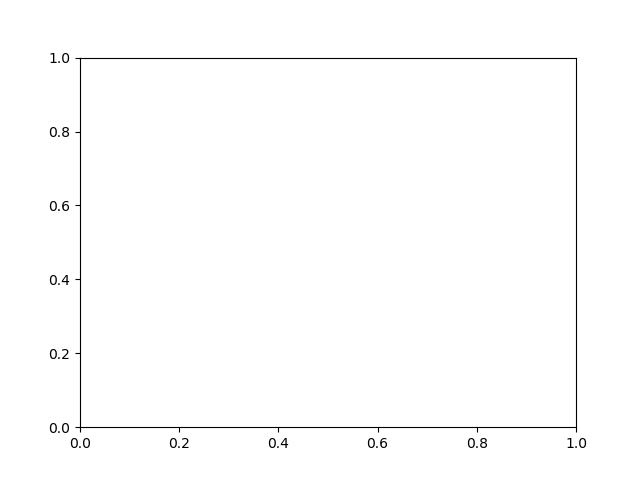

[2802 2946 4936 4640 1954 3090  907 3864 3924   71 1502 2194 3214 1045
 2128 3726 1227 2513 2593  597 2955 2472 2927  476 3251 4409 2607 4443
 4702 3047 3838 4950 3060 3518 1900 4190 4845 4117 2931 1319  952  607
 2212    2 2730  159 2861 2440 3855  856 1829 3353 1135 3952 1993 3798
  375 1262 1647 3401 1187 3123 2326  771 1316 4839 1025 3572 2760 3170
 4450 3447 1118 3067 3059  466 2482  550 1114 2330  985 3051 3440 3445
 3383 2383  495 3705 1891 3473 3787  266 4958 4302 3290 2676 3686 1270
   76 3368 1314 2243 3690 3656 1357  569 3884 2519 3738 1366 3411  477
 4370 1899 3231  443 4998 2529 1652  612  928 4521 4104   90  984 2495
 1248 3922 1844 3250 3531 3691 3701 2822 4978  544 1329 4509 3198 2146
  739 1182 3963 3277 2572  797 3714 2027 3207 1521 4458   54  874 2594
 3117 4730  741 1851 4722 2449 3476 2515  640 2566 1776 4230 3097 2154
 2051 2394 3559 2280 2333 3562 4118 3299 2715  600 4079  822 3704 3316
 4807 1379  800  143 3078 1164  561 4086  353 3859 3659 2880  343 1293
 4971 

In signal : tensor([1., 0.])

tensor([0.4726])
tensor([0.0570]) tensor([0.0731]) tensor(0.7229) tensor([0.7479])
tensor([0.0550]) tensor([1.0160]) tensor(0.5964) tensor([0.4982])

tensor([0.0580]) tensor([0.0694]) tensor(0.7229) tensor([0.7479])
tensor([0.0560]) tensor([0.9652]) tensor(0.5964) tensor([0.4982])
In signal : tensor([0., 1.])

tensor([0.5046])
tensor([0.0590]) tensor([1.0160]) tensor(0.7229) tensor([0.7479])
tensor([0.0827]) tensor([0.9169]) tensor(0.6967) tensor([0.7221])

tensor([0.0600]) tensor([0.9652]) tensor(0.7229) tensor([0.7479])
tensor([0.0837]) tensor([0.8711]) tensor(0.6967) tensor([0.7221])

tensor([0.0610]) tensor([0.9169]) tensor(0.7229) tensor([0.7479])
tensor([0.0847]) tensor([0.8275]) tensor(0.6967) tensor([0.7221])

tensor([0.0620]) tensor([0.8711]) tensor(0.7229) tensor([0.7479])
tensor([0.0857]) tensor([0.7861]) tensor(0.6967) tensor([0.7221])

tensor([0.0630]) tensor([0.8275]) tensor(0.7229) tensor([0.7479])
tensor([0.0867]) tensor([0.7468]) tensor(0.

tensor([0.4094]) tensor([0.6251]) tensor(0.7391) tensor([0.6316])

tensor([0.2678]) tensor([0.6580]) tensor(0.7481) tensor([0.8406])
tensor([0.4104]) tensor([0.5938]) tensor(0.7391) tensor([0.6316])

tensor([0.2688]) tensor([0.6251]) tensor(0.7481) tensor([0.8406])
tensor([0.4114]) tensor([0.5641]) tensor(0.7391) tensor([0.6316])

tensor([0.2698]) tensor([0.5938]) tensor(0.7481) tensor([0.8406])
tensor([0.4124]) tensor([0.5359]) tensor(0.7391) tensor([0.6316])

tensor([0.2708]) tensor([0.5641]) tensor(0.7481) tensor([0.8406])
tensor([0.4134]) tensor([0.5091]) tensor(0.7391) tensor([0.6316])

tensor([0.2718]) tensor([0.5359]) tensor(0.7481) tensor([0.8406])
tensor([0.4144]) tensor([0.4837]) tensor(0.7391) tensor([0.6316])

tensor([0.2728]) tensor([0.5091]) tensor(0.7481) tensor([0.8406])
tensor([0.4154]) tensor([0.4595]) tensor(0.7391) tensor([0.6316])

tensor([0.2738]) tensor([0.4837]) tensor(0.7481) tensor([0.8406])
tensor([0.4164]) tensor([0.4365]) tensor(0.7391) tensor([0.6316])

te

tensor([0.6456]) tensor([0.7311]) tensor(0.7714) tensor([0.4801])

tensor([0.4259]) tensor([0.7696]) tensor(0.7581) tensor([0.8575])
tensor([0.6466]) tensor([0.6946]) tensor(0.7714) tensor([0.4801])

tensor([0.4269]) tensor([0.7311]) tensor(0.7581) tensor([0.8575])
tensor([0.6476]) tensor([0.6598]) tensor(0.7714) tensor([0.4801])

tensor([0.4279]) tensor([0.6946]) tensor(0.7581) tensor([0.8575])
tensor([0.6486]) tensor([0.6268]) tensor(0.7714) tensor([0.4801])

tensor([0.4289]) tensor([0.6598]) tensor(0.7581) tensor([0.8575])
tensor([0.6496]) tensor([0.5955]) tensor(0.7714) tensor([0.4801])

tensor([0.4299]) tensor([0.6268]) tensor(0.7581) tensor([0.8575])
tensor([0.6506]) tensor([0.5657]) tensor(0.7714) tensor([0.4801])

tensor([0.4309]) tensor([0.5955]) tensor(0.7581) tensor([0.8575])
tensor([0.6516]) tensor([0.5374]) tensor(0.7714) tensor([0.4801])

tensor([0.4319]) tensor([0.5657]) tensor(0.7581) tensor([0.8575])
tensor([0.6526]) tensor([0.5106]) tensor(0.7714) tensor([0.4801])

te

tensor([0.4869]) tensor([0.0337]) tensor(0.7581) tensor([0.8575])
tensor([0.7076]) tensor([0.0304]) tensor(0.7714) tensor([0.4801])

tensor([0.4879]) tensor([0.0320]) tensor(0.7581) tensor([0.8575])
tensor([0.7086]) tensor([0.0289]) tensor(0.7714) tensor([0.4801])

tensor([0.4889]) tensor([0.0304]) tensor(0.7581) tensor([0.8575])
tensor([0.7096]) tensor([0.0274]) tensor(0.7714) tensor([0.4801])

tensor([0.4899]) tensor([0.0289]) tensor(0.7581) tensor([0.8575])
tensor([0.7106]) tensor([0.0261]) tensor(0.7714) tensor([0.4801])

tensor([0.4909]) tensor([0.0274]) tensor(0.7581) tensor([0.8575])
tensor([0.7116]) tensor([0.0248]) tensor(0.7714) tensor([0.4801])

tensor([0.4919]) tensor([0.0261]) tensor(0.7581) tensor([0.8575])
tensor([0.7126]) tensor([0.0235]) tensor(0.7714) tensor([0.4801])

tensor([0.4929]) tensor([0.0248]) tensor(0.7581) tensor([0.8575])
tensor([0.7136]) tensor([0.0223]) tensor(0.7714) tensor([0.4801])

tensor([0.4939]) tensor([0.0235]) tensor(0.7581) tensor([0.8575])
ten

tensor([0.8496]) tensor([0.2273]) tensor(0.7736) tensor([0.4467])

tensor([0.5498]) tensor([0.2393]) tensor(0.7677) tensor([0.9270])
tensor([0.8506]) tensor([0.2160]) tensor(0.7736) tensor([0.4467])

tensor([0.5508]) tensor([0.2273]) tensor(0.7677) tensor([0.9270])
tensor([0.8516]) tensor([0.2052]) tensor(0.7736) tensor([0.4467])

tensor([0.5518]) tensor([0.2160]) tensor(0.7677) tensor([0.9270])
tensor([0.8526]) tensor([0.1949]) tensor(0.7736) tensor([0.4467])

tensor([0.5528]) tensor([0.2052]) tensor(0.7677) tensor([0.9270])
tensor([0.8536]) tensor([0.1852]) tensor(0.7736) tensor([0.4467])

tensor([0.5538]) tensor([0.1949]) tensor(0.7677) tensor([0.9270])
tensor([0.8546]) tensor([0.1759]) tensor(0.7736) tensor([0.4467])

tensor([0.5548]) tensor([0.1852]) tensor(0.7677) tensor([0.9270])
tensor([0.8556]) tensor([0.1671]) tensor(0.7736) tensor([0.4467])

tensor([0.5558]) tensor([0.1759]) tensor(0.7677) tensor([0.9270])
tensor([0.8566]) tensor([0.1588]) tensor(0.7736) tensor([0.4467])

te

In signal : tensor([0., 1.])

tensor([0.3970])
tensor([0.7106]) tensor([1.5298]) tensor(0.8307) tensor([0.7823])
spike tensor([0.7106])
tensor([0.9119]) tensor([0.8574]) tensor(0.9963) tensor([0.5368])

tensor([0.6750]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9129]) tensor([0.8145]) tensor(0.9963) tensor([0.5368])

tensor([0.6760]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9139]) tensor([0.7738]) tensor(0.9963) tensor([0.5368])

tensor([0.6770]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9149]) tensor([0.7351]) tensor(0.9963) tensor([0.5368])

tensor([0.6780]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9159]) tensor([0.6983]) tensor(0.9963) tensor([0.5368])

tensor([0.6790]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9169]) tensor([0.6634]) tensor(0.9963) tensor([0.5368])

tensor([0.6800]) tensor([0.]) tensor(0.8307) tensor([0.7823])
tensor([0.9179]) tensor([0.6302]) tensor(0.9963) tensor([0.5368])

tensor([0.6810]) tensor

tensor([0.7360]) tensor([0.1221]) tensor(0.8544) tensor([0.8911])
tensor([0.9420]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7370]) tensor([0.1160]) tensor(0.8544) tensor([0.8911])
tensor([0.9430]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7380]) tensor([0.1102]) tensor(0.8544) tensor([0.8911])
tensor([0.9440]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7390]) tensor([0.1047]) tensor(0.8544) tensor([0.8911])
tensor([0.9450]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7400]) tensor([0.0994]) tensor(0.8544) tensor([0.8911])
tensor([0.9460]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7410]) tensor([0.0945]) tensor(0.8544) tensor([0.8911])
tensor([0.9470]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7420]) tensor([0.0897]) tensor(0.8544) tensor([0.8911])
tensor([0.9480]) tensor([0.]) tensor(1.1036) tensor([0.7684])

tensor([0.7430]) tensor([0.0853]) tensor(0.8544) tensor([0.8911])
tensor([0.9490]) tensor([0.]) t

spike tensor([0.9057])
In signal : tensor([0., 1.])

tensor([0.3504])
tensor([0.8558]) tensor([0.9500]) tensor(0.8968) tensor([0.9576])
tensor([0.8937]) tensor([0.]) tensor(1.1388) tensor([0.9710])
In signal : tensor([0., 1.])

tensor([0.3502])
tensor([0.8568]) tensor([1.8525]) tensor(0.8968) tensor([0.9576])
spike tensor([0.8568])
tensor([0.8947]) tensor([0.]) tensor(1.1392) tensor([0.9855])

tensor([0.8424]) tensor([0.]) tensor(0.8968) tensor([0.9576])
tensor([0.8957]) tensor([0.]) tensor(1.1392) tensor([0.9855])

tensor([0.8434]) tensor([0.]) tensor(0.8968) tensor([0.9576])
tensor([0.8967]) tensor([0.]) tensor(1.1392) tensor([0.9855])

tensor([0.8444]) tensor([0.]) tensor(0.8968) tensor([0.9576])
tensor([0.8977]) tensor([0.]) tensor(1.1392) tensor([0.9855])

tensor([0.8454]) tensor([0.]) tensor(0.8968) tensor([0.9576])
tensor([0.8987]) tensor([0.]) tensor(1.1392) tensor([0.9855])

tensor([0.8464]) tensor([0.]) tensor(0.8968) tensor([0.9576])
tensor([0.8997]) tensor([0.]) tensor(1.13

tensor([0.9888]) tensor([0.1047]) tensor(1.3584) tensor([0.6545])

tensor([0.9014]) tensor([0.1102]) tensor(0.8977) tensor([0.9788])
tensor([0.9898]) tensor([0.0994]) tensor(1.3584) tensor([0.6545])

tensor([0.9024]) tensor([0.1047]) tensor(0.8977) tensor([0.9788])
tensor([0.9908]) tensor([0.0945]) tensor(1.3584) tensor([0.6545])

tensor([0.9034]) tensor([0.0994]) tensor(0.8977) tensor([0.9788])
tensor([0.9918]) tensor([0.0897]) tensor(1.3584) tensor([0.6545])

tensor([0.9044]) tensor([0.0945]) tensor(0.8977) tensor([0.9788])
tensor([0.9928]) tensor([0.0853]) tensor(1.3584) tensor([0.6545])

tensor([0.9054]) tensor([0.0897]) tensor(0.8977) tensor([0.9788])
tensor([0.9938]) tensor([0.0810]) tensor(1.3584) tensor([0.6545])
In signal : tensor([1., 0.])

tensor([0.4434])
tensor([0.9392]) tensor([0.0853]) tensor(0.8995) tensor([0.9489])
tensor([0.9948]) tensor([1.0269]) tensor(1.3584) tensor([0.6545])
spike tensor([0.9948])

tensor([0.9402]) tensor([0.0810]) tensor(0.8995) tensor([0.9489])


tensor([0.9408]) tensor([1.1759]) tensor(1.6281) tensor([0.6475])
spike tensor([0.9408])

tensor([0.9524]) tensor([0.]) tensor(1.0685) tensor([0.9320])
tensor([0.9063]) tensor([0.]) tensor(1.6281) tensor([0.6475])
In signal : tensor([0., 1.])

tensor([0.2394])
tensor([0.9534]) tensor([0.9500]) tensor(1.0685) tensor([0.9320])
spike tensor([0.9534])
tensor([0.9073]) tensor([0.]) tensor(1.6902) tensor([0.8238])
In signal : tensor([1., 0.])

tensor([0.3726])
tensor([0.9061]) tensor([0.]) tensor(1.0708) tensor([0.9660])
tensor([0.9083]) tensor([0.9500]) tensor(1.6902) tensor([0.8238])

tensor([0.9071]) tensor([0.]) tensor(1.0708) tensor([0.9660])
tensor([0.9093]) tensor([0.9025]) tensor(1.6902) tensor([0.8238])
In signal : tensor([0., 1.])

tensor([0.2260])
tensor([0.9081]) tensor([0.9500]) tensor(1.0708) tensor([0.9660])
tensor([0.9372]) tensor([0.8574]) tensor(1.8148) tensor([0.5742])

tensor([0.9091]) tensor([0.9025]) tensor(1.0708) tensor([0.9660])
tensor([0.9382]) tensor([0.8145]) tens

tensor([0.8971]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9486]) tensor([0.3972]) tensor(2.0899) tensor([0.6092])

tensor([0.8981]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9496]) tensor([0.3774]) tensor(2.0899) tensor([0.6092])

tensor([0.8991]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9506]) tensor([0.3585]) tensor(2.0899) tensor([0.6092])

tensor([0.9001]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9516]) tensor([0.3406]) tensor(2.0899) tensor([0.6092])

tensor([0.9011]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9526]) tensor([0.3235]) tensor(2.0899) tensor([0.6092])

tensor([0.9021]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9536]) tensor([0.3074]) tensor(2.0899) tensor([0.6092])

tensor([0.9031]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9546]) tensor([0.2920]) tensor(2.0899) tensor([0.6092])

tensor([0.9041]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([0.9556]) tensor([0.2774]) t

tensor([1.0116]) tensor([0.0157]) tensor(2.0899) tensor([0.6092])

tensor([0.9611]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0126]) tensor([0.0149]) tensor(2.0899) tensor([0.6092])

tensor([0.9621]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0136]) tensor([0.0142]) tensor(2.0899) tensor([0.6092])

tensor([0.9631]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0146]) tensor([0.0135]) tensor(2.0899) tensor([0.6092])

tensor([0.9641]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0156]) tensor([0.0128]) tensor(2.0899) tensor([0.6092])

tensor([0.9651]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0166]) tensor([0.0121]) tensor(2.0899) tensor([0.6092])

tensor([0.9661]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0176]) tensor([0.0115]) tensor(2.0899) tensor([0.6092])

tensor([0.9671]) tensor([0.]) tensor(1.2999) tensor([0.9198])
tensor([1.0186]) tensor([0.0110]) tensor(2.0899) tensor([0.6092])

tensor([0.9681]) tensor([0.]) 

tensor([0.8755]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9377]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8765]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9387]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8775]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9397]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8785]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9407]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8795]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9417]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8805]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9427]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8815]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9437]) tensor([0.]) tensor(2.1901) tensor([0.9511])

tensor([0.8825]) tensor([0.]) tensor(1.3042) tensor([0.9900])
tensor([0.9447]) tensor([0.]) tensor(2.1901) tensor([0.9511])



tensor([0.9404]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9035]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9414]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9045]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9424]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9055]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9434]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9065]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9444]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9075]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9454]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9085]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9464]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9095]) tensor([0.]) tensor(1.5992) tensor([0.8263])
tensor([0.9474]) tensor([0.]) tensor(2.4641) tensor([0.8252])

tensor([0.9105]) tensor([0.]) tensor(1.5992) tensor([0.8263])


tensor([0.9038]) tensor([0.]) tensor(2.4832) tensor([0.9563])

tensor([0.9148]) tensor([0.2039]) tensor(1.6180) tensor([0.9566])
tensor([0.9048]) tensor([0.]) tensor(2.4832) tensor([0.9563])
In signal : tensor([1., 0.])

tensor([0.2456])
tensor([0.9515]) tensor([0.1937]) tensor(1.6280) tensor([0.8861])
tensor([0.9058]) tensor([0.9500]) tensor(2.4832) tensor([0.9563])

tensor([0.9525]) tensor([0.1840]) tensor(1.6280) tensor([0.8861])
tensor([0.9068]) tensor([0.9025]) tensor(2.4832) tensor([0.9563])
In signal : tensor([0., 1.])

tensor([0.1556])
tensor([0.9535]) tensor([1.1248]) tensor(1.6280) tensor([0.8861])
spike tensor([0.9535])
tensor([0.9264]) tensor([0.8574]) tensor(2.6819) tensor([0.6411])

tensor([0.9170]) tensor([0.]) tensor(1.6280) tensor([0.8861])
tensor([0.9274]) tensor([0.8145]) tensor(2.6819) tensor([0.6411])

tensor([0.9180]) tensor([0.]) tensor(1.6280) tensor([0.8861])
tensor([0.9284]) tensor([0.7738]) tensor(2.6819) tensor([0.6411])

tensor([0.9190]) tensor([0.]) tensor

tensor([0.9039]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9246]) tensor([0.4877]) tensor(1.6361) tensor([0.9715])
tensor([0.9049]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9256]) tensor([0.4633]) tensor(1.6361) tensor([0.9715])
tensor([0.9059]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9266]) tensor([0.4401]) tensor(1.6361) tensor([0.9715])
tensor([0.9069]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9276]) tensor([0.4181]) tensor(1.6361) tensor([0.9715])
tensor([0.9079]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9286]) tensor([0.3972]) tensor(1.6361) tensor([0.9715])
tensor([0.9089]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9296]) tensor([0.3774]) tensor(1.6361) tensor([0.9715])
tensor([0.9099]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9306]) tensor([0.3585]) tensor(1.6361) tensor([0.9715])
tensor([0.9109]) tensor([0.]) tensor(2.7624) tensor([0.9103])

tensor([0.9316]) tensor([0.3406]) 

tensor([0.9794]) tensor([0.9500]) tensor(1.6662) tensor([0.9223])
spike tensor([0.9794])
tensor([0.9067]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9338]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9077]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9348]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9087]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9358]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9097]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9368]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9107]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9378]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9117]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9388]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9127]) tensor([0.]) tensor(3.1140) tensor([0.7373])

tensor([0.9398]) tensor([0.]) tensor(1.6662) tensor([0.9223])
tensor([0.9137]) tensor([0.]) tensor

spike tensor([0.9434])

tensor([0.9724]) tensor([0.]) tensor(1.6699) tensor([0.9806])
tensor([0.8955]) tensor([0.]) tensor(3.1485) tensor([0.8687])
In signal : tensor([0., 1.])

tensor([0.1266])
tensor([0.9734]) tensor([0.9500]) tensor(1.6699) tensor([0.9806])
spike tensor([0.9734])
tensor([0.8965]) tensor([0.]) tensor(3.1572) tensor([0.9343])

tensor([0.9274]) tensor([0.]) tensor(1.6699) tensor([0.9806])
tensor([0.8975]) tensor([0.]) tensor(3.1572) tensor([0.9343])
In signal : tensor([1., 0.])

tensor([0.2389])
tensor([0.9284]) tensor([0.]) tensor(1.6701) tensor([0.9903])
tensor([0.8985]) tensor([0.9500]) tensor(3.1572) tensor([0.9343])

tensor([0.9294]) tensor([0.]) tensor(1.6701) tensor([0.9903])
tensor([0.8995]) tensor([0.9025]) tensor(3.1572) tensor([0.9343])
In signal : tensor([0., 1.])

tensor([0.1241])
tensor([0.9304]) tensor([0.9500]) tensor(1.6701) tensor([0.9903])
spike tensor([0.9304])
tensor([0.9156]) tensor([0.8574]) tensor(3.3401) tensor([0.6319])

tensor([0.8816]) tenso

tensor([0.9406]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8930]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9416]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8940]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9426]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8950]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9436]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8960]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9446]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8970]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9456]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8980]) tensor([0.]) tensor(3.4248) tensor([0.9080])

tensor([0.9466]) tensor([0.]) tensor(1.6949) tensor([0.8840])
tensor([0.8990]) tensor([0.]) tensor(3.4248) tensor([0.9080])
In signal : tensor([1., 0.])

tensor([0.2348])
tensor([0.9476]) tensor([0.]) tensor(1.7016) tensor([0.9420])
tensor([0.9000]) 

tensor([0.9312]) tensor([0.]) tensor(1.7658) tensor([0.9233])
tensor([0.9342]) tensor([1.2735]) tensor(4.0607) tensor([0.5756])
spike tensor([0.9342])

tensor([0.9322]) tensor([0.]) tensor(1.7658) tensor([0.9233])
tensor([0.9042]) tensor([0.]) tensor(4.0607) tensor([0.5756])
In signal : tensor([1., 1.])

tensor([0.2257])
tensor([0.0977])
tensor([0.9332]) tensor([0.9500]) tensor(1.7688) tensor([0.9617])
spike tensor([0.9332])
tensor([0.9052]) tensor([0.9500]) tensor(4.1508) tensor([0.7878])

tensor([0.8846]) tensor([0.]) tensor(1.7688) tensor([0.9617])
tensor([0.9062]) tensor([0.9025]) tensor(4.1508) tensor([0.7878])
In signal : tensor([0., 1.])

tensor([0.0955])
tensor([0.8856]) tensor([0.9500]) tensor(1.7688) tensor([0.9617])
tensor([0.9187]) tensor([0.8574]) tensor(4.2574) tensor([0.5570])
In signal : tensor([1., 0.])

tensor([0.2109])
tensor([0.9106]) tensor([0.9025]) tensor(1.9789) tensor([0.6376])
tensor([0.9197]) tensor([1.7645]) tensor(4.2574) tensor([0.5570])
spike tensor([0.91

tensor([0.8974]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9009]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.8984]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9019]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.8994]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9029]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.9004]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9039]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.9014]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9049]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.9024]) tensor([0.]) tensor(4.6108) tensor([0.8054])

tensor([0.9059]) tensor([0.]) tensor(2.0686) tensor([0.8945])
tensor([0.9034]) tensor([0.]) tensor(4.6108) tensor([0.8054])
In signal : tensor([1., 0.])

tensor([0.1926])
tensor([0.9069]) tensor([0.]) tensor(2.0742) tensor([0.9472])
tensor([0.9044]) tensor([0.9500]) tensor(4.6108) tensor([0.8054])

tensor([0.90

tensor([0.9687]) tensor([0.0595]) tensor(4.7254) tensor([0.5660])

tensor([0.9619]) tensor([0.0627]) tensor(2.0742) tensor([0.9472])
tensor([0.9697]) tensor([0.0566]) tensor(4.7254) tensor([0.5660])

tensor([0.9629]) tensor([0.0595]) tensor(2.0742) tensor([0.9472])
tensor([0.9707]) tensor([0.0537]) tensor(4.7254) tensor([0.5660])

tensor([0.9639]) tensor([0.0566]) tensor(2.0742) tensor([0.9472])
tensor([0.9717]) tensor([0.0510]) tensor(4.7254) tensor([0.5660])

tensor([0.9649]) tensor([0.0537]) tensor(2.0742) tensor([0.9472])
tensor([0.9727]) tensor([0.0485]) tensor(4.7254) tensor([0.5660])

tensor([0.9659]) tensor([0.0510]) tensor(2.0742) tensor([0.9472])
tensor([0.9737]) tensor([0.0461]) tensor(4.7254) tensor([0.5660])

tensor([0.9669]) tensor([0.0485]) tensor(2.0742) tensor([0.9472])
tensor([0.9747]) tensor([0.0438]) tensor(4.7254) tensor([0.5660])

tensor([0.9679]) tensor([0.0461]) tensor(2.0742) tensor([0.9472])
tensor([0.9757]) tensor([0.0416]) tensor(4.7254) tensor([0.5660])

te

tensor([1.0229]) tensor([0.0027]) tensor(2.0742) tensor([0.9472])
tensor([1.0307]) tensor([0.0025]) tensor(4.7254) tensor([0.5660])

tensor([1.0239]) tensor([0.0026]) tensor(2.0742) tensor([0.9472])
tensor([1.0317]) tensor([0.0024]) tensor(4.7254) tensor([0.5660])

tensor([1.0249]) tensor([0.0025]) tensor(2.0742) tensor([0.9472])
tensor([1.0327]) tensor([0.0022]) tensor(4.7254) tensor([0.5660])

tensor([1.0259]) tensor([0.0024]) tensor(2.0742) tensor([0.9472])
tensor([1.0337]) tensor([0.0021]) tensor(4.7254) tensor([0.5660])

tensor([1.0269]) tensor([0.0022]) tensor(2.0742) tensor([0.9472])
tensor([1.0347]) tensor([0.0020]) tensor(4.7254) tensor([0.5660])

tensor([1.0279]) tensor([0.0021]) tensor(2.0742) tensor([0.9472])
tensor([1.0357]) tensor([0.0019]) tensor(4.7254) tensor([0.5660])

tensor([1.0289]) tensor([0.0020]) tensor(2.0742) tensor([0.9472])
tensor([1.0367]) tensor([0.0018]) tensor(4.7254) tensor([0.5660])
In signal : tensor([1., 0.])

tensor([0.1923])
tensor([1.0303]) tensor

tensor([1.0055]) tensor([0.]) tensor(4.8432) tensor([0.8915])

tensor([0.9984]) tensor([0.]) tensor(2.0758) tensor([0.9863])
tensor([1.0065]) tensor([0.]) tensor(4.8432) tensor([0.8915])

tensor([0.9994]) tensor([0.]) tensor(2.0758) tensor([0.9863])
tensor([1.0075]) tensor([0.]) tensor(4.8432) tensor([0.8915])

tensor([1.0004]) tensor([0.]) tensor(2.0758) tensor([0.9863])
tensor([1.0085]) tensor([0.]) tensor(4.8432) tensor([0.8915])

tensor([1.0014]) tensor([0.]) tensor(2.0758) tensor([0.9863])
tensor([1.0095]) tensor([0.]) tensor(4.8432) tensor(4.8491) tensor([0.9457])

tensor([0.9994]) tensor([0.]) tensor(2.0759) tensor([0.9931])
tensor([1.0079]) tensor([0.]) tensor(4.8491) tensor([0.9457])

tensor([1.0004]) tensor([0.]) tensor(2.0759) tensor([0.9931])
tensor([1.0089]) tensor([0.]) tensor(4.8491) tensor([0.9457])

tensor([1.0014]) tensor([0.]) tensor(2.0759) tensor([0.9931])
tensor([1.0099]) tensor([0.]) tensor(4.8491) tensor([0.9457])

tensor([1.0024]) tensor([0.]) tensor(2.0759) te

tensor([0.9797]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9714]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9807]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9724]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9817]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9734]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9827]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9744]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9837]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9754]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9847]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9764]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9857]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9774]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([0.9867]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([0.9784]) tensor([0.]) tensor(2.0759) tensor([0.9983])


tensor([1.0364]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0457]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0374]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0467]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0384]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0477]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0394]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0487]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0404]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0497]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0414]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0507]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0424]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0517]) tensor([0.]) tensor(4.8509) tensor([0.9864])

tensor([1.0434]) tensor([0.]) tensor(2.0759) tensor([0.9983])
tensor([1.0527]) tensor([0.]) tensor(4.8509) tensor([0.9864])



tensor([1.0605]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0703]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0615]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0713]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0625]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0723]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0635]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0733]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0645]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0743]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0655]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0753]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0665]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0763]) tensor([0.]) tensor(4.8510) tensor([0.9932])

tensor([1.0675]) tensor([0.]) tensor(2.0759) tensor([0.9991])
tensor([1.0773]) tensor([0.]) tensor(4.8510) tensor([0.9932])



tensor([1.0116]) tensor([0.]) tensor(4.8510) tensor([0.9983])
In signal : tensor([0., 1.])

tensor([0.0822])
tensor([1.0439]) tensor([0.9500]) tensor(2.0760) tensor([0.9999])
spike tensor([1.0439])
tensor([1.0126]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0024]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0136]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0034]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0146]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0044]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0156]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0054]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0166]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0064]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0176]) tensor([0.]) tensor(4.8510) tensor([0.9992])

tensor([1.0074]) tensor([0.]) tensor(2.0760) tensor([0.9999])
tensor([1.0186]) tensor([0.]) tensor(4.8510) tensor(

tensor([0.9393]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9272]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9403]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9282]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9413]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9292]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9423]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9302]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9433]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9312]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9443]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9322]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9453]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9332]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9463]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9342]) tensor([0.]) tensor(2.0760) tensor([1.0000])


tensor([0.9567]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9439]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9577]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9449]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9587]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9459]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9597]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9469]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9607]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9479]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9617]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9489]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9627]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9499]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9637]) tensor([0.]) tensor(4.8510) tensor([0.9999])

tensor([0.9509]) tensor([0.]) tensor(2.0760) tensor([1.0000])


tensor([0.9248]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9104]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9258]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9114]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9268]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9124]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9278]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9134]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9288]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9144]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9298]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9154]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9308]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9164]) tensor([0.]) tensor(2.0760) tensor([1.0000])
tensor([0.9318]) tensor([0.]) tensor(4.8510) tensor([1.0000])

tensor([0.9174]) tensor([0.]) tensor(2.0760) tensor([1.0000])


KeyboardInterrupt: 

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 5000
x_fire = np.array(random.sample(range(1,epochs), epochs // 25))
y_fire = (x_fire + 2)
print(x_fire)
#x_fire = []
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)
    
    
    if 1 in in_stream:
        print("In signal : {}".format(in_stream.data))
        
    print()    
    #print()
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    #draw_spikes(s,[2,1], ax)
    #fig.canvas.draw()
    #time.sleep(0.1)

In [ ]:
print(torch.tanh(torch.tensor(0.87)))